In [1]:
import environment
import baseline
import utils
import IQL
import visualization
import io_utils

import time
import os

/home/rania/Public/anaconda3/envs/jupyter_base/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


In [2]:
configuration = {
    "max_cycles": 10, 
    "x_size": 12,"y_size": 12, 
    "shared_reward": True, 
    "n_evaders": 2, "n_pursuers": 8,
    "obs_range": 7, 
    "n_catch": 2, 
    "freeze_evaders": False, 
    "tag_reward": 0.5, "catch_reward": 10.0, "urgency_reward": -1, 
    "surround": True, 
    "constraint_window": 1.0
}

# Fonctions de base

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


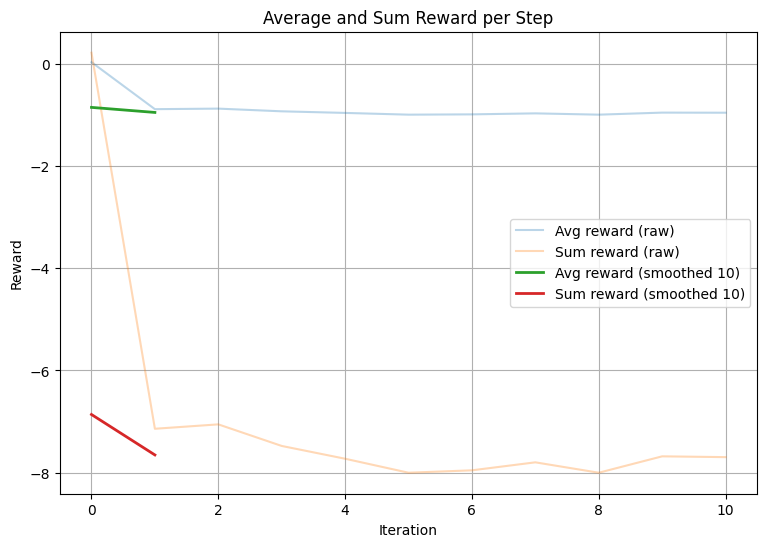

Saved run 23 to data.csv


In [3]:
environment.start_AEC(configuration)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


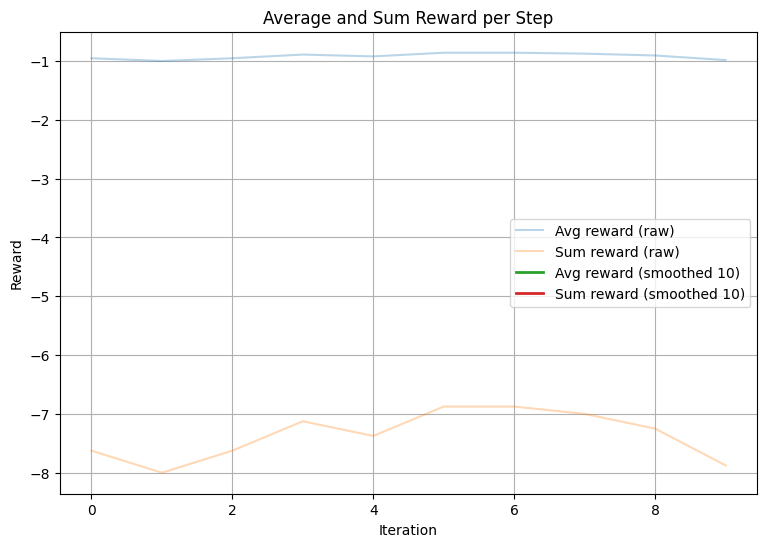

Saved run 30 to data.cvs


In [4]:
environment.start_parallel(configuration)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


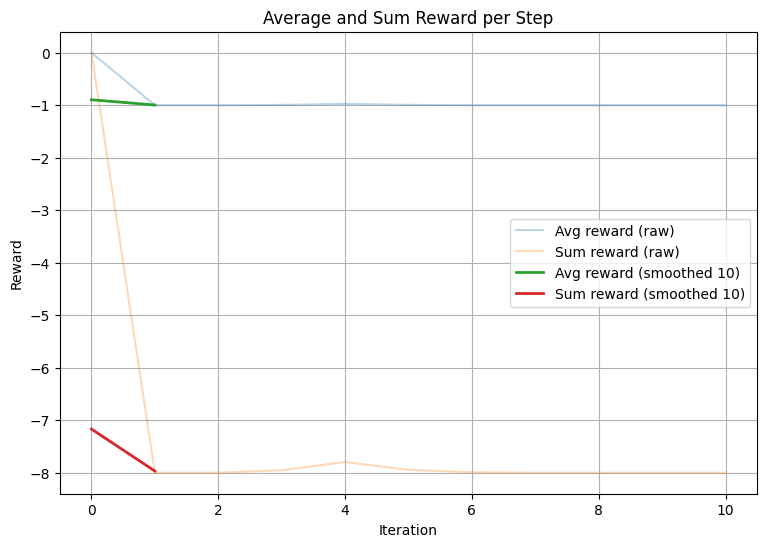

Saved run 24 to data.csv


In [5]:
environment.start_AEC(configuration, baseline.frantic_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


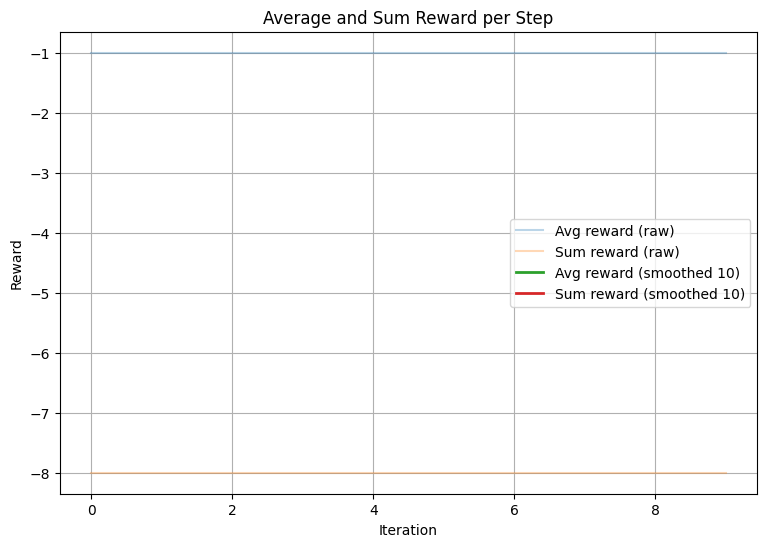

Saved run 31 to data.cvs


In [6]:
environment.start_parallel(configuration, baseline.frantic_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


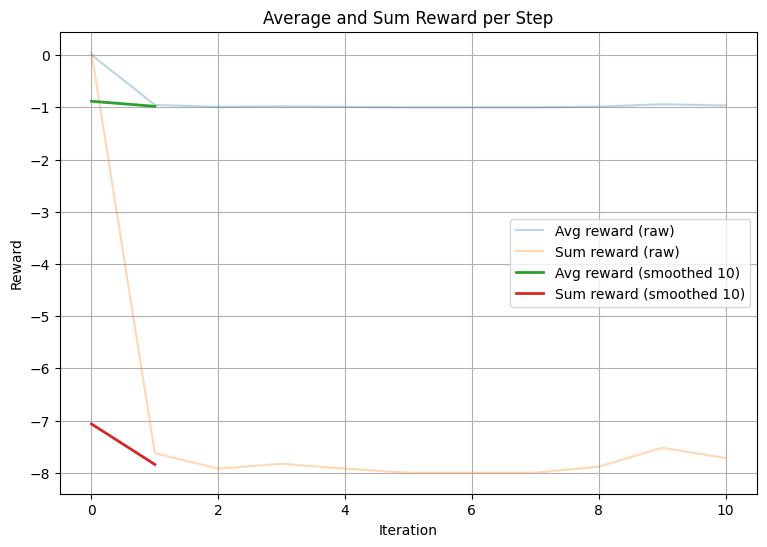

Saved run 25 to data.csv


In [7]:
environment.start_AEC(configuration, baseline.coward_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


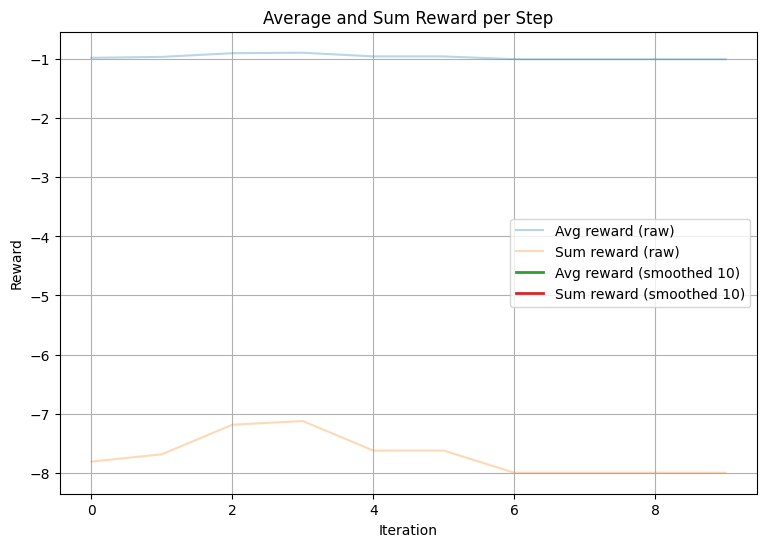

Saved run 32 to data.cvs


In [8]:
environment.start_parallel(configuration, baseline.coward_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


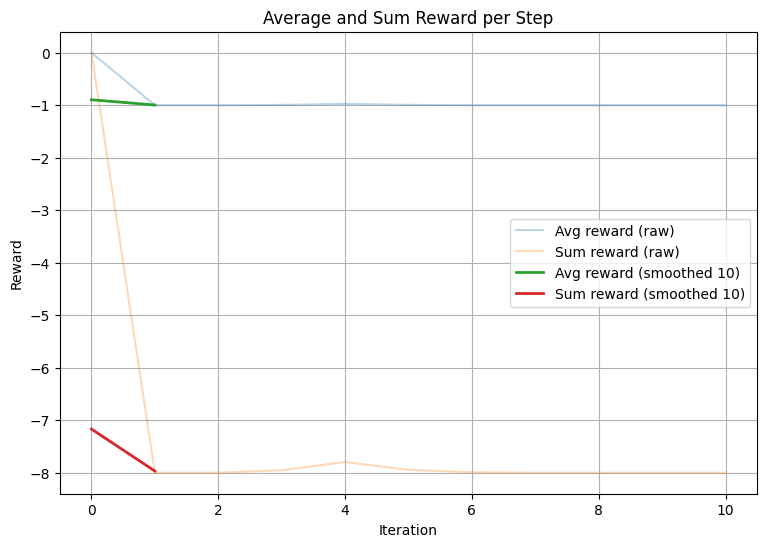

Saved run 26 to data.csv


In [9]:
environment.start_AEC(configuration, baseline.group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


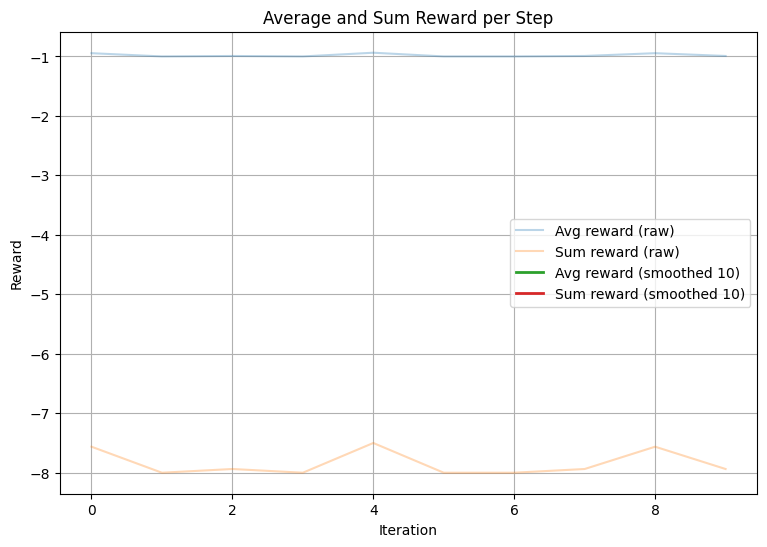

Saved run 33 to data.cvs


In [10]:
environment.start_parallel(configuration, baseline.group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


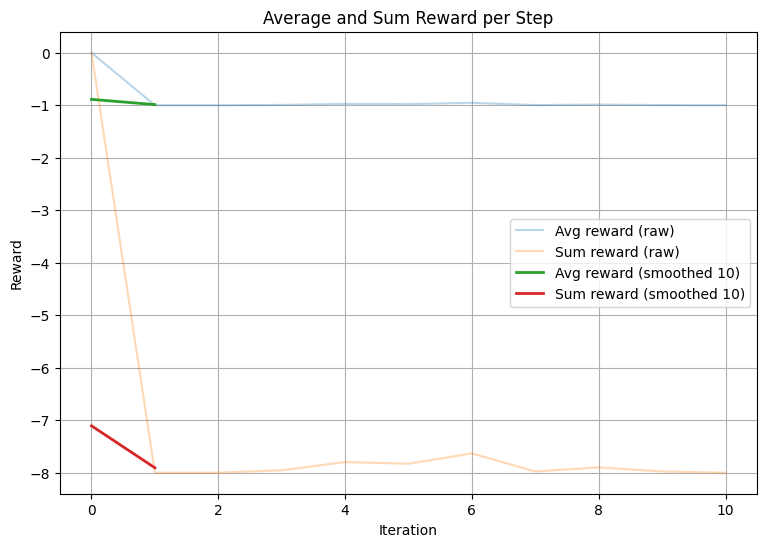

Saved run 27 to data.csv


In [11]:
environment.start_AEC(configuration, baseline.border_guided_group_chase)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


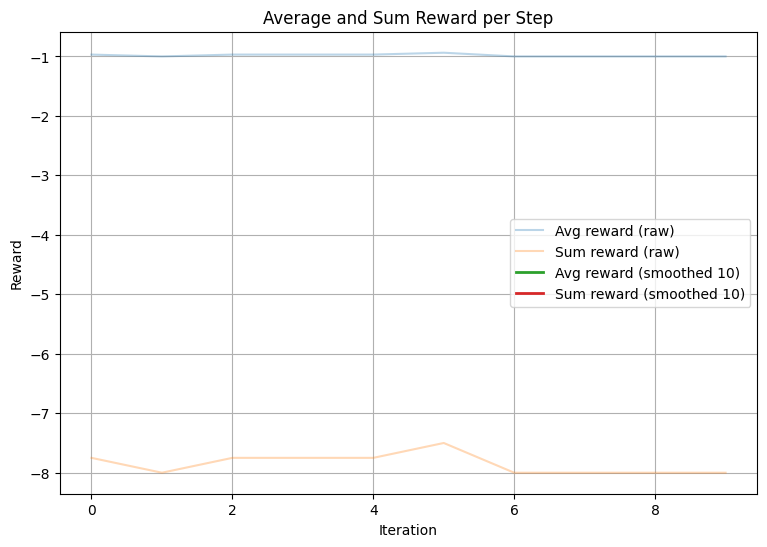

Saved run 34 to data.cvs


In [12]:
environment.start_parallel(configuration, baseline.border_guided_group_chase)

# MARL

On commence par effectuer des choix sur le réseaux de neurones centrale de notre algorithme MARL. Puisque on cherche à extraire des features de donnée positionnelle, on va commencer par des couches CNN. On s'équipe d'une buffer duquelle on échantionne les expériences passées. En Q-learning, on sélectionne l'action à la Q valeur la plus grande, on effectue cela de manière epsilon greedy pour garder la flexibilité. On équipe chaque agent de deux réseaux de neurones 
Dans l'approche IQL on a des agents indépendants qui disposent chacun de leur instances RL et s'entraineent de manière simultannée sur le même environnement

In [13]:
configuration_1 = {
    "max_cycles": 10, 
    "x_size": 12,"y_size": 12, 
    "shared_reward": True, 
    "n_evaders": 2, "n_pursuers": 8,
    "obs_range": 7, 
    "n_catch": 2, 
    "freeze_evaders": False, 
    "tag_reward": 0.5, "catch_reward": 10.0, "urgency_reward": -1, 
    "surround": True, 
    "constraint_window": 1.0
}


model_name = "test_1"
os.makedirs(f"./{model_name}", exist_ok=True)

RETRAIN = True

In [14]:
if RETRAIN:
    start_time = time.perf_counter()
    marl_agents, rewards, lengths, losses, metadata = environment.train_IQL(configuration_1,
                                                                            model_name,
                                                                            n_episodes=1,
                                                                            batch_size=258,
                                                                            epsilon_decay=0.995)
    print(time.perf_counter() - start_time)

Using device: cuda
Observation shape: (7, 7, 3)
Number of actions: 5
Number of agents: 8

IQL training started...

IQL training complete!
0.9167129019988352


Plot saved to ./test_1/training_plot_IQL


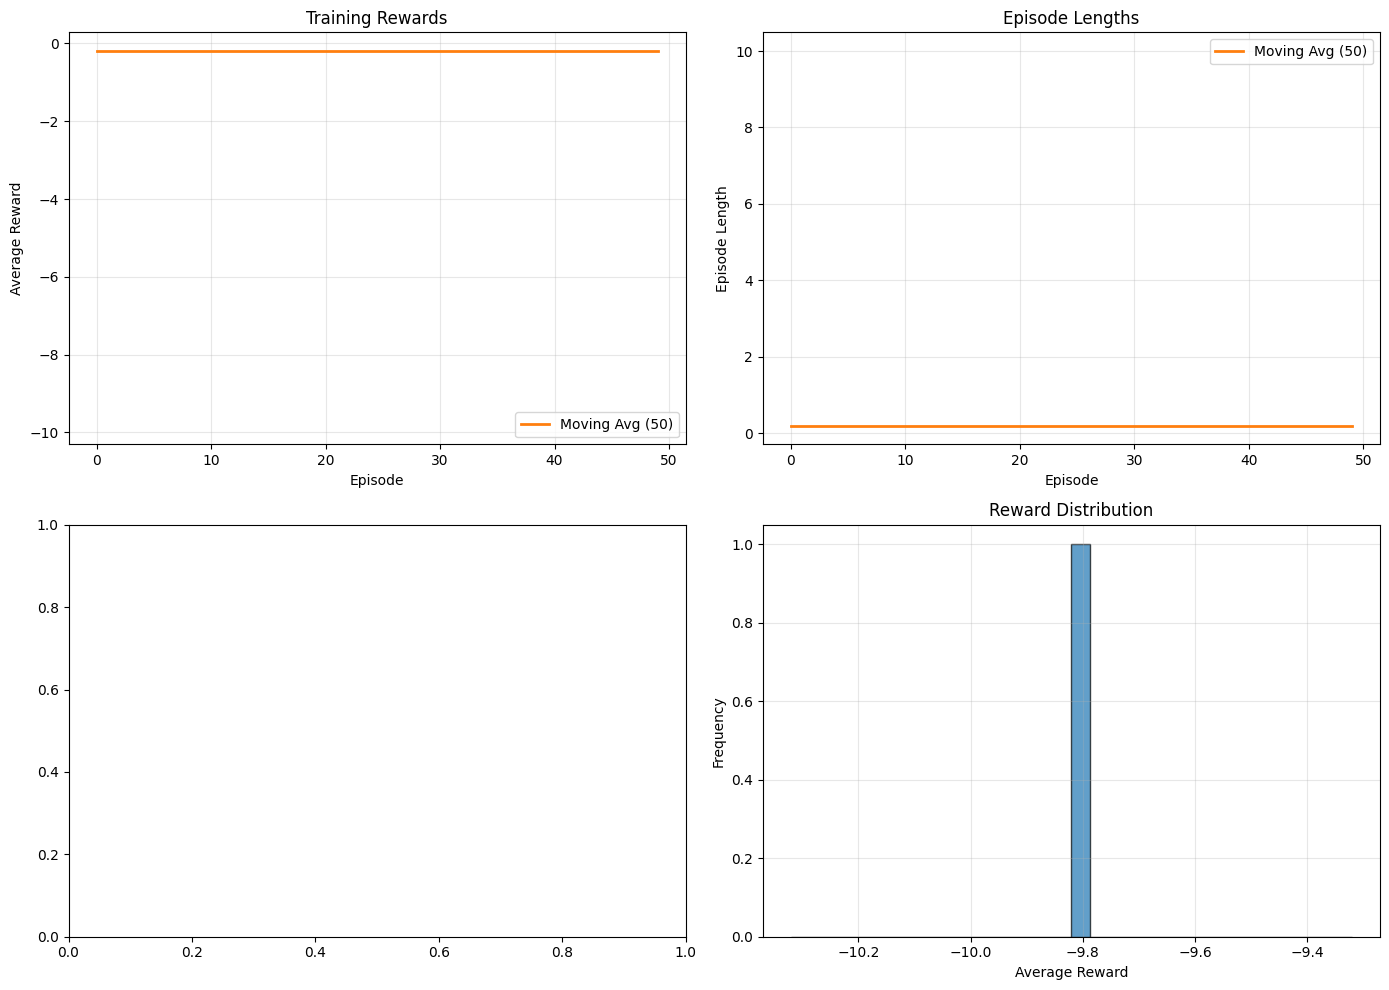

In [15]:
if RETRAIN:
    visualization.plot_training_results(rewards, lengths, losses, save_path=f"./{model_name}/training_plot_IQL")

In [16]:
if RETRAIN:
    rewards, lengths, success, action_counts = environment.eval_IQL(configuration_1, marl_agents, n_episodes=1)


IQL evaluation started...
Episode 1: Avg Reward = -9.87, Steps = 10, Success = 0

IQL evaluation complete!

Evaluation Summary:
Mean Reward: -9.87
Std Reward: 0.00
Mean Episode Length: 10.00
Success Rate: 0.00


Plot saved to ./test_1/eval_plot_IQL


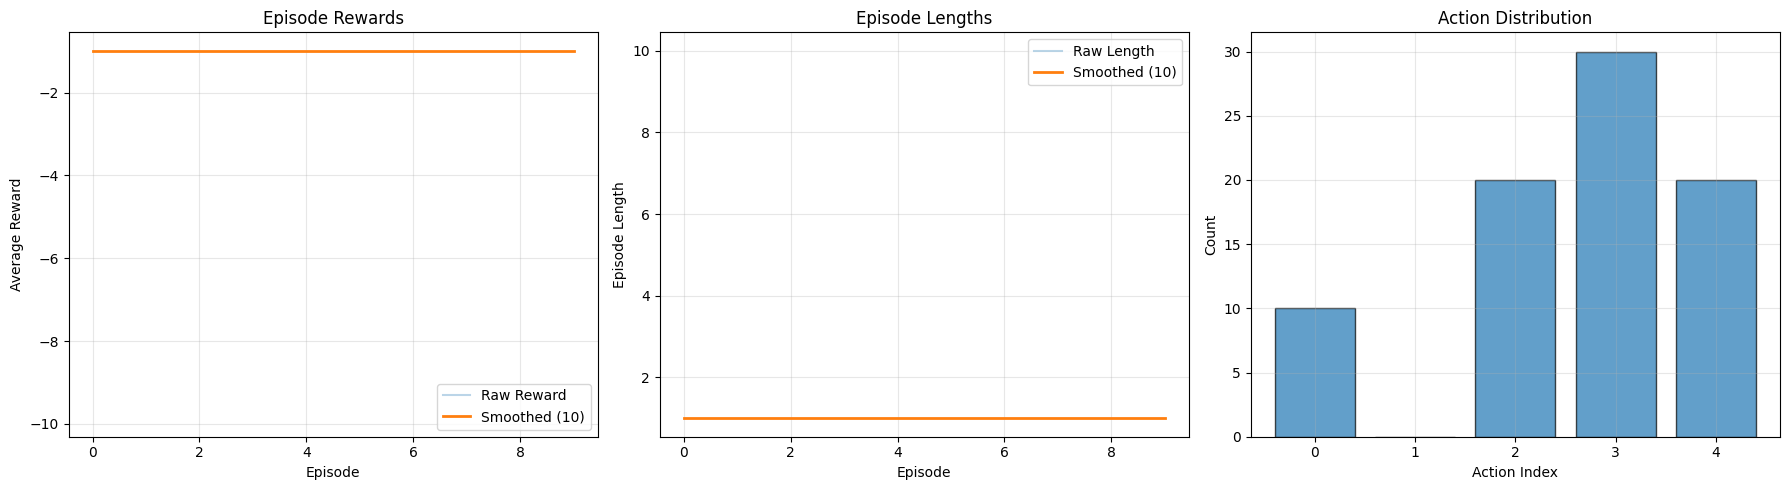

In [17]:
if RETRAIN:
    visualization.plot_eval_metrics(rewards, lengths, action_counts, save_path=f"./{model_name}/eval_plot_IQL")

In [18]:
if RETRAIN:
    start_time = time.perf_counter()
    qmix_agent, rewards, lengths, losses, metadata = environment.train_QMIX(configuration_1,
                                                                            model_name,
                                                                            n_episodes=1,
                                                                            batch_size=258,
                                                                            epsilon_decay=0.995)
    print(time.perf_counter() - start_time)

Using device: cuda
Observation shape: (7, 7, 3)
Number of actions: 5
Number of agents: 8

QMIX training started...

QMIX training complete!
Model saved to ./test_1/QMIX.pth
0.04796562300180085


Plot saved to ./test_1/training_plot_QMix


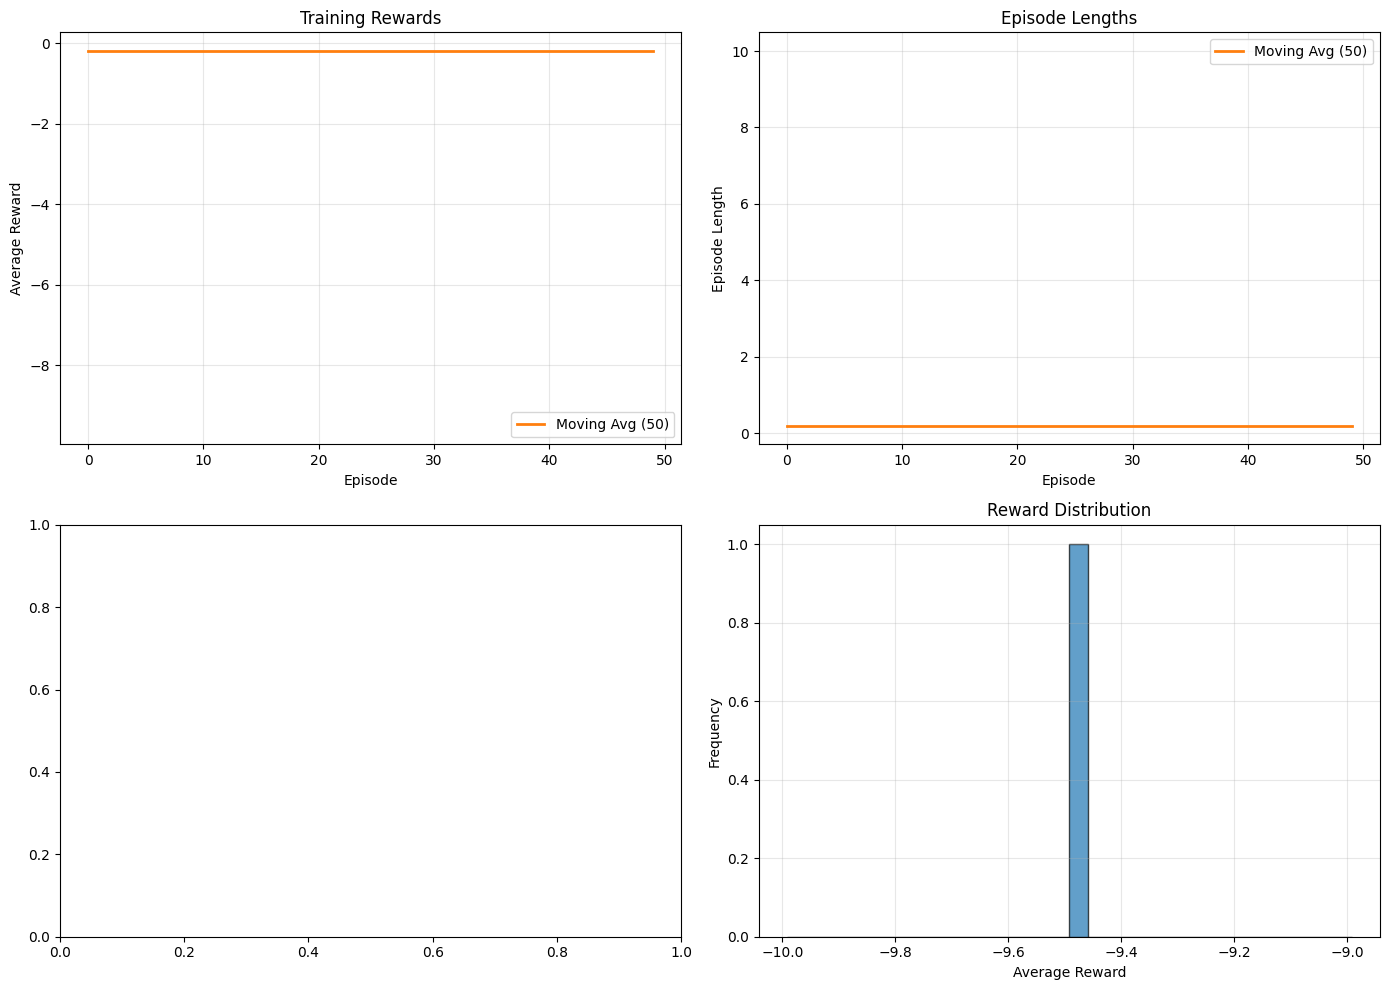

In [19]:
if RETRAIN:
    visualization.plot_training_results(rewards, lengths, losses, save_path=f"./{model_name}/training_plot_QMix")

In [20]:
if RETRAIN:
    rewards, lengths, success, action_counts = environment.eval_QMIX(configuration_1,
                                                                     qmix_agent,
                                                                     n_episodes=1,
                                                                     render=False)


QMIX evaluation started...
Episode 1: Avg Reward = -9.52, Steps = 10, Success = 0

QMIX evaluation complete!

Evaluation Summary:
Mean Reward: -9.52
Std Reward: 0.00
Mean Episode Length: 10.00
Success Rate: 0.00


Plot saved to ./test_1/eval_plot_QMix


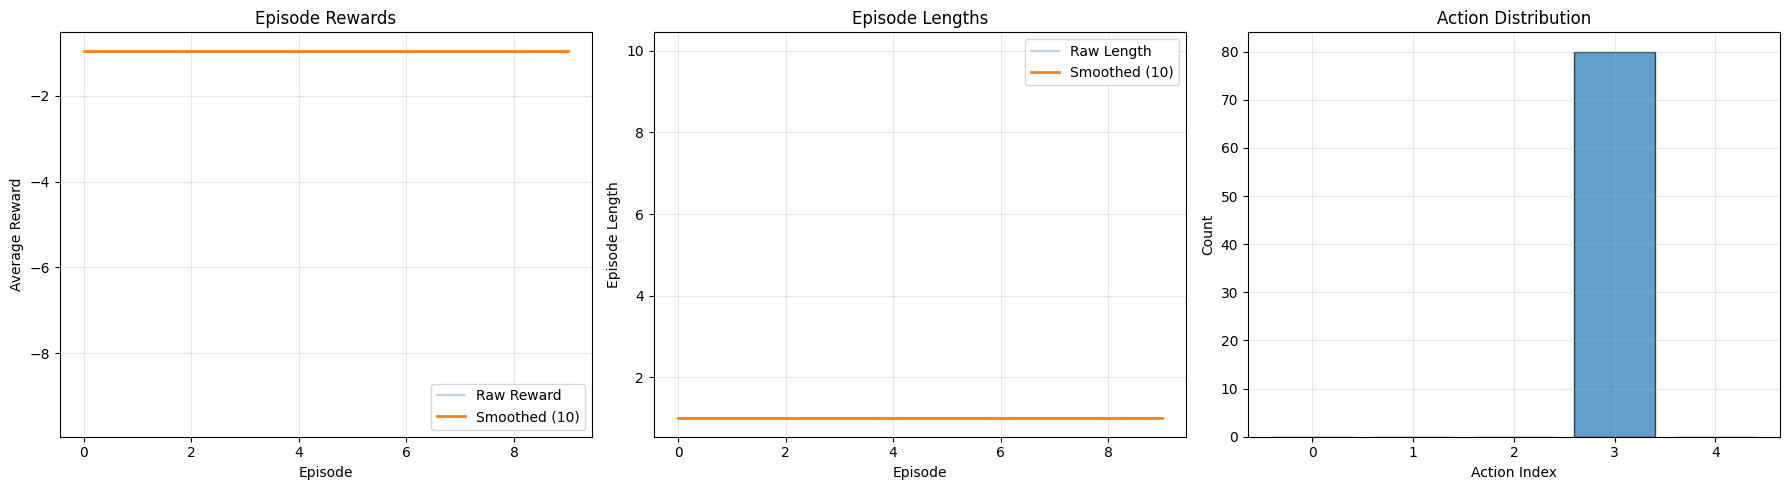

In [21]:
if RETRAIN:
    visualization.plot_eval_metrics(rewards, lengths, action_counts, save_path=f"./{model_name}/eval_plot_QMix")

In [22]:
marl_agents = io_utils.load_IQL(model_name, configuration_1)
qmix_agent = io_utils.load_QMIX(f"./{model_name}/QMIX.pth")
iql_policy = io_utils.marl_agents_to_policy(marl_agents, epsilon=0.0)
qmix_policy = io_utils.qmix_agent_to_policy(qmix_agent, epsilon=0.0)

Using device: cuda
Loaded IQL agents from 'test_1'
Loaded QMIX agent from './test_1/QMIX.pth'


agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


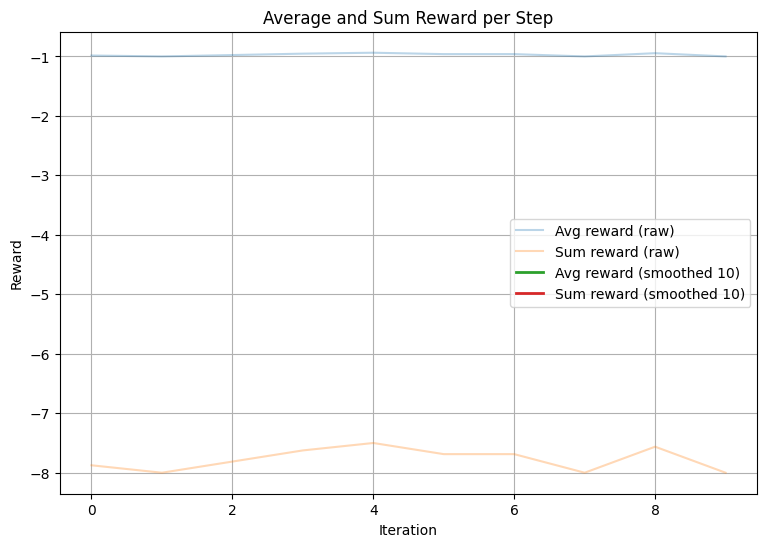

Saved run 35 to data.cvs


In [23]:
environment.start_parallel(configuration, iql_policy)

agent pursuer_0 truncated
agent pursuer_1 truncated
agent pursuer_2 truncated
agent pursuer_3 truncated
agent pursuer_4 truncated
agent pursuer_5 truncated
agent pursuer_6 truncated
agent pursuer_7 truncated
pursuit failed, interrupted after 10 steps.


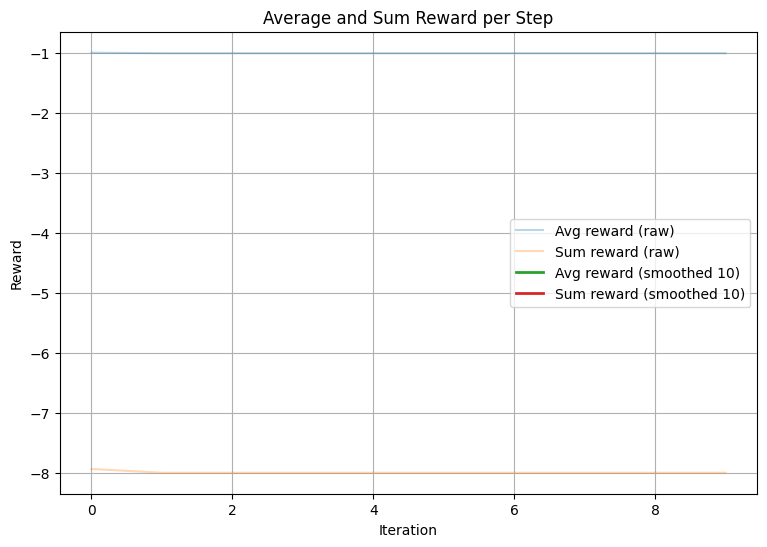

Saved run 36 to data.cvs


In [24]:
environment.start_parallel(configuration, qmix_policy)